# Importing Necessary Libraries
This section imports all the necessary libraries required for the rest of the notebook.

In [1]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands

!pip install openai
!pip install gradio
!pip install tiktoken
!pip install faiss-cpu
!pip install  datasets
# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [2]:

import openai
openai.api_key = "Openai_token"

# Downloading Dataset
This section downloads the dataset using the wget command.

In [3]:
 !wget -nc https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/6a91fb201929394a4c640ed32a29b69136c1a6f7/Dataset/bbc_text_cls.csv


'wget' is not recognized as an internal or external command,
operable program or batch file.


# Importing Necessary Libraries


In [4]:
# text-embedding-3-small	$0.02 / 1M tokens
# text-embedding-3-large	$0.13 / 1M tokens

import tiktoken
import pandas as pd
import numpy as np

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")


# Read Data and Calcuate Tokens

there are token =  1068453


,text,labels,num_token
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,564
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,461
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,344
3,High fuel prices hit BA's profits\n\nBritish A...,business,557
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,391
...,...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,tech,503
2221,Spam e-mails tempt net shoppers\n\nComputer us...,tech,435
2222,Be careful how you code\n\nA new European dire...,tech,1205
2223,US cyber security chief resigns\n\nThe man mak...,tech,439


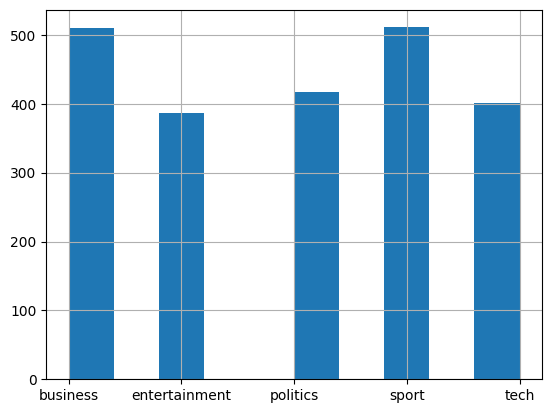

In [5]:
def update_total(text):
    ints = encoding.encode(text)
    num_token = len(ints)
    return num_token



df = pd.read_csv('./bbc_text_cls.csv')
df['num_token']= df['text'].apply(update_total)

print("there are token = ", df['num_token'].sum())

df['labels'].hist()

df

In [6]:
from IPython.display import Markdown, display

idx = 0

display(Markdown(df.loc[idx, "labels"]))
display(Markdown("===================================="))
display(Markdown(df.loc[idx, "text"]))

business

====================================

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.

Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. "Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility," chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.

TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.

# Reduce Size

there are token =  55100


<Axes: >

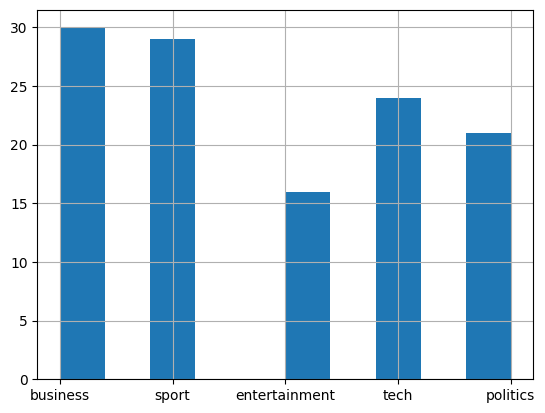

In [7]:
df_small = df.sample(120).reset_index(drop=True)
print("there are token = ", df_small['num_token'].sum())
df_small['labels'].hist()

# Generate Embeddings


In [8]:
def get_embedding(text):
    text = text.replace("\n", "")
    emb = openai.embeddings.create(
        input=[text],
        model='text-embedding-3-small',
    )
    emb = np.array(emb.data[0].embedding).reshape(1, -1)
    # normalize
    emb = emb / np.linalg.norm(emb)

    return emb




In [9]:
df_small['embeddings'] = df_small['text'].apply(get_embedding)

df_small

df_small.to_pickle("small_embedded.pkl")

In [9]:
embedding_vector = np.concatenate(df_small['embeddings'].tolist(), dtype="float32")
embedding_vector.shape

(120, 1536)

# Create and Populate the FAISS Index
We will use FAISS, a library for efficient similarity search and clustering of dense vectors, to create an index and add our image embeddings to it.

In [ ]:
import faiss

# Create and populate the Faiss index
d = embedding_vector.shape[1]  # Dimension of the embeddings

index = faiss.IndexFlatL2(d)
index.reset()

print("Number of vectors in the index: ", index.ntotal)
print("number of dimension = ", d)

In [11]:
# clear the index
index.reset()
# add the embedding vector to the index
index.add(embedding_vector)
print("Number of vectors in the index: ", index.ntotal)


Number of vectors in the index:  120


# Perform a Search with a Query

In [12]:
# Perform a search
def search_text(query, k=5):
    query_embedding = get_embedding(query).astype("float32")
    # norทalize the query embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    distances, indices = index.search(query_embedding, k)

    return distances[0], indices[0]


In [13]:
query = """By what percentage did China's economy expand in 2004?"""
distances, top_k_indices = search_text(query, k=5)

In [14]:
top_k_indices

array([ 96,  86, 100,  18,  32], dtype=int64)

In [15]:
distances

array([1.2957531, 1.3563339, 1.4133863, 1.4392895, 1.4588511],
      dtype=float32)

# Display the Results

In [16]:
print("Query:", query)
print("====================================")

for i, idx in enumerate(top_k_indices):
    if idx < 0:
        continue
    print(f"Rank {i+1}:")
    print("class = ",df_small.loc[idx, "labels"])
    print("distance = ", distances[i])
    print(df_small.loc[idx, "text"])
    print("====================================")

Query: By what percentage did China's economy expand in 2004?
Rank 1:
class =  business
distance =  1.2957531
S Korean consumers spending again

South Korea looks set to sustain its revival thanks to renewed private consumption, its central bank says.

The country's economy has suffered from an overhang of personal debt after its consumers' credit card spending spree. Card use fell sharply last year, but is now picking up again with a rise in spending of 14.8% year-on-year. "The economy is now heading upward rather than downward," said central bank governor Park Seung. "The worst seems to have passed." Mr Park's statement came as the bank decided to keep interest rates at an all-time low of 3.25%. It had cut rates in November to help revive the economy, but rising inflation - reaching 0.7% month-on-month in January - has stopped it from cutting further. Economic growth in 2004 was about 4.7%, with the central bank predicting 4% growth this year. Other indicators are also suggesting tha

# Apply to LLM with LLAMA3 (cannot run the same file in local but work on Colab)

In [17]:
!pip install transformers accelerate datasets bitsandbytes

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [18]:
import os
os.environ['HF_TOKEN'] ="hf_token"
hf_token               = os.environ['HF_TOKEN']

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False



# Load the entire model on the GPU 0
device_map = {"": 0}


In [19]:
from transformers import AutoModelForCausalLM,AutoTokenizer,BitsAndBytesConfig
import torch

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

model     = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config,device_map="auto",token=hf_token)
tokenizer = AutoTokenizer.from_pretrained(model_id)


: 

In [35]:
def generate_response(prompt, max_tokens=512, temperature=0.6, top_p=0.9):

    messages = [
        {"role": "system", "content": "You are an economist who do analysis and reserch about world economy."},
        {"role": "user", "content": prompt},
    ]

    input_ids = tokenizer.apply_chat_template(messages,add_generation_prompt=True,return_tensors="pt").to(model.device)


    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=max_tokens,
        pad_token_id=model.config.eos_token_id,
        eos_token_id=terminators,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
    )

    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response, skip_special_tokens=True)


In [42]:
def qa(question, context):
    prompt = f"""Please answer the question given the provided \
    context.

    Question:

    ```
    {question}
    ```

    Context:

    ```
    {context}
    ```
    """

    result_txt = generate_response(prompt)
    return result_txt

In [43]:
with_specific_txt = qa(query, df_small.iloc[top_k_indices[0]].text)
IPython.display.Markdown(with_specific_txt)

According to the World Bank, China's GDP growth rate in 2004 was 9.5%.

In [44]:
completion = generate_response(query)

# pretty format the response
IPython.display.Markdown(completion)

According to the World Bank, China's GDP growth rate in 2004 was approximately 9.5%. This was a remarkable growth rate, driven by a combination of factors such as rapid urbanization, investment in infrastructure, and export-led growth.

![](https://deeplearningcourses.com/notebooks_v3_pxl?sc=AVRK7SgM9ASkQf5TAqs_wA&n=Embeddings+and+RAG)